In [127]:
import io
from pathlib import Path
import re

import fasttext
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
import wordcloud

from jjuoda_dl4 import utils

sns.set_context("talk")
BASE_DATA_DIR = utils.BASE_DATA_DIR
FIGURES_DIR = utils.BASE_FIGURES_DIR / "eda"

In [128]:
df_true = pd.read_csv(BASE_DATA_DIR / "raw" / "True.csv")
df_true.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [129]:
df_fake = pd.read_csv(BASE_DATA_DIR / "raw" / "Fake.csv")
df_fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [130]:
df_true["is_fake"] = False
df_merged = pd.concat([df_true, df_fake])
df_merged["is_fake"].fillna(True, inplace=True)
df_merged.reset_index(drop=True, inplace=True)

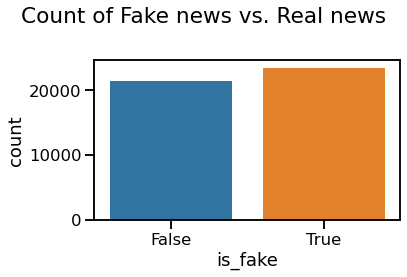

In [131]:
sns.countplot(x="is_fake", data=df_merged)
plt.suptitle("Count of Fake news vs. Real news")
plt.tight_layout()
plt.savefig(Path().cwd().parent / "figures/eda" / "is_fake_countplot.png")

<AxesSubplot:xlabel='count', ylabel='subject'>

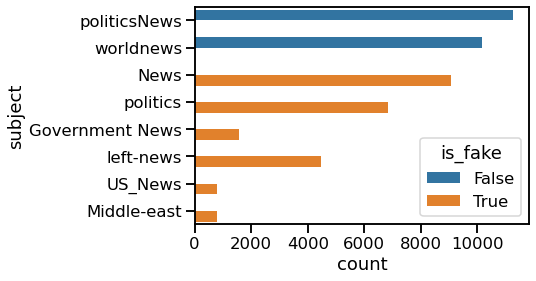

In [132]:
sns.countplot(y="subject", data=df_merged, hue="is_fake")

It doesn't seem that subjects overlap at all.

In [133]:
df_merged["num_words_text"] = df_merged["text"].str.strip().str.split().str.len()

In [134]:
df_merged["num_words_text"].describe()

count    44898.000000
mean       405.282284
std        351.265595
min          0.000000
25%        203.000000
50%        362.000000
75%        513.000000
max       8135.000000
Name: num_words_text, dtype: float64

In [135]:
df_merged[df_merged["num_words_text"] == 0]

,title,text,subject,date,is_fake,num_words_text
8970,Graphic: Supreme Court roundup,,politicsNews,"June 16, 2016",False,0
32340,TAKE OUR POLL: Who Do You Think President Trum...,,politics,"May 10, 2017",True,0
32458,Joe Scarborough BERATES Mika Brzezinski Over “...,,politics,"Apr 26, 2017",True,0
32607,WATCH TUCKER CARLSON Scorch Sanctuary City May...,,politics,"Apr 6, 2017",True,0
32642,MAYOR OF SANCTUARY CITY: Trump Trying To Make ...,,politics,"Apr 2, 2017",True,0
...,...,...,...,...,...,...
43233,BALTIMORE BURNS: MARYLAND GOVERNOR BRINGS IN N...,,left-news,"Apr 27, 2015",True,0
43243,FULL VIDEO: THE BLOCKBUSTER INVESTIGATION INTO...,,left-news,"Apr 25, 2015",True,0
43244,(VIDEO) HILLARY CLINTON: RELIGIOUS BELIEFS MUS...,,left-news,"Apr 25, 2015",True,0
43274,(VIDEO)ICE PROTECTING OBAMA: WON’T RELEASE NAM...,,left-news,"Apr 14, 2015",True,0


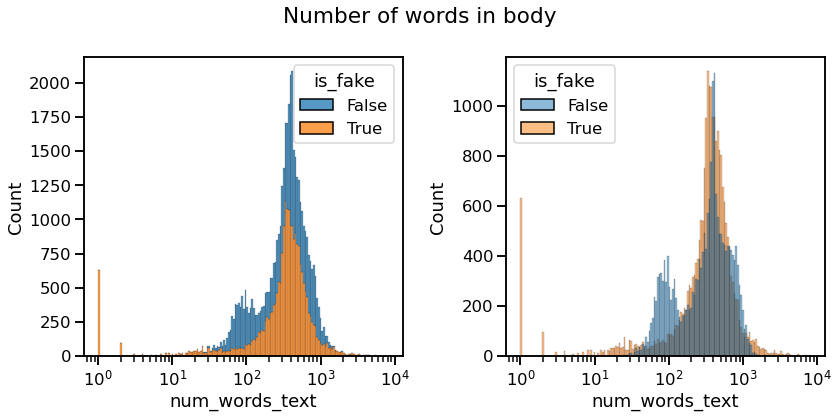

In [136]:
plt.figure(figsize=(12, 6))

plt.suptitle("Number of words in body")

plt.subplot(1, 2, 1)
sns.histplot(
    x=df_merged.num_words_text + 1,
    hue=df_merged.is_fake,
    log_scale=(True, False),
    multiple="stack",
)

plt.subplot(1, 2, 2)
sns.histplot(
    x=df_merged.num_words_text + 1,
    hue=df_merged.is_fake,
    log_scale=(True, False),
    multiple="layer",
)

plt.tight_layout()

plt.savefig(FIGURES_DIR / "num_words_body_histplot.png")

In [137]:
wc_true = wordcloud.WordCloud(width=650, height=400, background_color="white").generate(
    " ".join(df_true.text)
)
wc_fake = wordcloud.WordCloud(width=650, height=400, background_color="white").generate(
    " ".join(df_fake.text)
)

'True news word cloud'

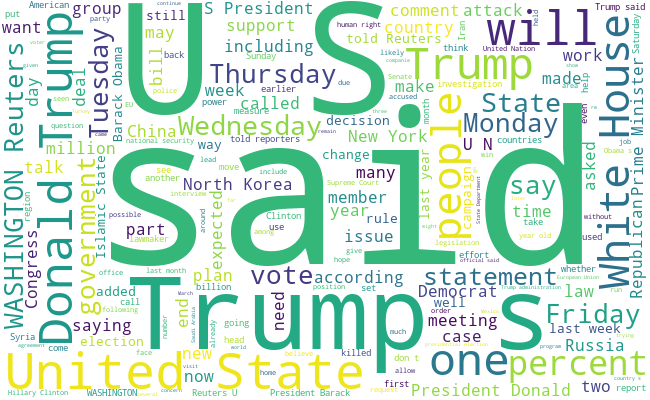

In [138]:
display("True news word cloud", wc_true.to_image())

'Fake news word cloud'

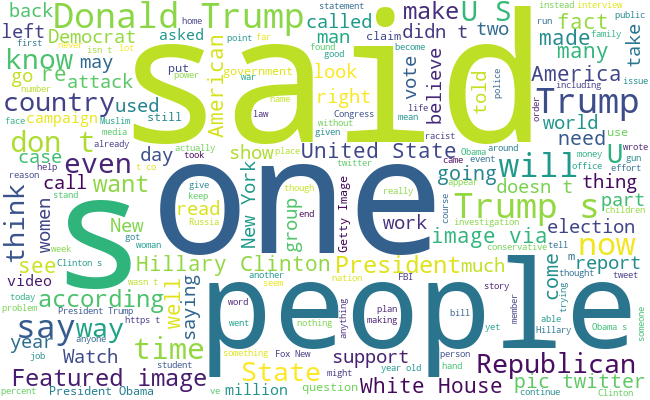

In [139]:
display("Fake news word cloud", wc_fake.to_image())

Honestly, it's hard to see something useful here. News are mostly about Donald Trump or USA in general.

In [140]:
vect_true = TfidfVectorizer(
    max_features=20,
    strip_accents="ascii",
    analyzer="word",
    lowercase=True,
    stop_words=wc_true.stopwords,
).fit(df_true.text)

/home/julius/.conda/envs/jjuoda-DL.4/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  warnings.warn(


In [141]:
vect_true.get_feature_names_out()

array(['election', 'government', 'house', 'last', 'new', 'one', 'people',
       'president', 'republican', 'reuters', 'said', 'state', 'states',
       'told', 'trump', 'two', 'united', 'washington', 'will', 'year'],
      dtype=object)

In [142]:
vect_fake = TfidfVectorizer(
    max_features=20,
    strip_accents="ascii",
    analyzer="word",
    lowercase=True,
    stop_words=wc_fake.stopwords,
).fit(df_fake.text)
vect_fake.get_feature_names_out()

array(['clinton', 'donald', 'even', 'hillary', 'new', 'news', 'now',
       'obama', 'one', 'people', 'president', 're', 'said', 'state',
       'time', 'trump', 'us', 'via', 'white', 'will'], dtype=object)

I see Reuters being mentioned in true news a lot. Fake news mention Hillary Clinton and Barack Obama quite a bit.

In [143]:
with pd.option_context("display.max_colwidth", None):
    print(df_true.sample(frac=1).head(5).text)

20538                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

In [144]:
print(
    f"True positives of 'Reuters' rule: {df_true.text.apply(lambda x: 'reuters' in x.lower()).mean():.3f}"
)

True positives of 'Reuters' rule: 0.998


In [145]:
print(
    f"False positives of 'Reuters' rule: {df_fake.text.apply(lambda x: 'reuters' in x.lower()).mean():.3f}"
)

False positives of 'Reuters' rule: 0.014


In [146]:
print(
    f"Accuracy of 'Reuters' rule: {(df_merged.text.apply(lambda x: 'reuters' not in x.lower()) == df_merged.is_fake).mean():.3f}"
)

Accuracy of 'Reuters' rule: 0.992


In [147]:
df_merged["reuters_rule"] = df_merged.text.apply(lambda x: "reuters" in x.lower())
counts = df_merged.groupby("reuters_rule").is_fake.value_counts()

In [148]:
counts = counts.reset_index(level=["reuters_rule"])
counts.columns = ["Mentions Reuters", "count"]
counts.reset_index(inplace=True)

In [149]:
counts

,is_fake,Mentions Reuters,count
0,True,False,23159
1,False,False,39
2,False,True,21378
3,True,True,322


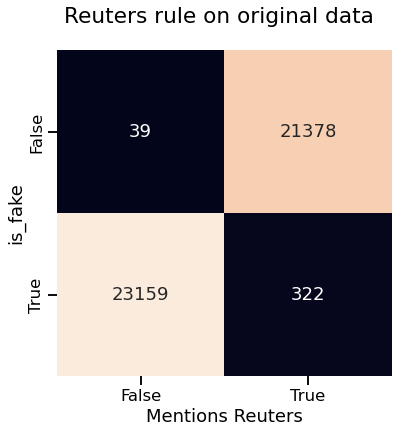

In [150]:
counts = counts.pivot(values="count", columns="Mentions Reuters", index="is_fake")

plt.figure(figsize=(6, 6))

sns.heatmap(counts, annot=True, fmt="d", cbar=False)
plt.suptitle("Reuters rule on original data")
plt.savefig(FIGURES_DIR / "reuters_rule.png")

Seems like only reuters news were taken and if I leave that, any model will just learn to check if reuters exist in the text.

In [151]:
with pd.option_context("display.max_colwidth", None):
    print(df_fake.sample(frac=1).head(5).text)

13378    Hillary and Bill Clinton have no shame! They ve both been lying to the American people for 30 years! From Bill s sexual exploits to Hillary s e-mails, they both have told the BIGGEST WHOOPERS that would have gotten any normal person in much more trouble! It s like the Clintons get a pass and that the rules don t apply to them ever! Sooo  fast forward to Hillary s DNC acceptance speech where she tells yet another tall tale. You won t believe how she basically throws a town under the bus to make herself look like a compassionate humanitarian. The problem is that some sharp people busted her for the lie LOL! From The New Bedford Standard Times April 17, 2015 in an article by Steve Urbon:The idealistic young woman with the long hair and huge eyeglasses had just graduated from Yale Law School, the future holding nothing but potential. But instead of shipping off to a New York or Washington law firm, she joined Marian Wright Edelman s fledgling Children s Defense Fund (which Edelman

Hm, there seems to be disconnected apostrophes and missing punctuation in general. The texts also feel more emotional. Somes "news" from Breitbart. Also feels like Twitter.

In [152]:
def drop_news_source_names(text):
    # signs of Reuters
    location_reuters_pat = r"^([A-Z/,. ]+ )?\(Reuters\) - "
    text = re.sub(location_reuters_pat, "", text, flags=re.IGNORECASE)
    reuters_in_text_pat = r"Reuters"
    text = re.sub(reuters_in_text_pat, "", text, flags=re.IGNORECASE)

    # signs of Breitbart
    breitbart_pat = r"Breitbart( News)?"
    text = re.sub(breitbart_pat, "", text, flags=re.IGNORECASE)

    # Signs of Twitter

    # I'm not sure if this needs dropping; the "news" is that Trump said something on Twitter, which is verifiably true
    # If we remove the disclaimer, what's left is Trump's tweet itself which can be false
    # I guess w/e, 4 samples in total have this disclaimer :D
    twitter_disclaimer_pat = r"^The following statements were posted to the verified Twitter accounts of U.S. President Donald Trump, @realDonaldTrump and @POTUS.  The opinions expressed are his own.  has not edited the statements or confirmed their accuracy."
    text = re.sub(twitter_disclaimer_pat, "", text, flags=re.IGNORECASE)
    twitter_replies_pat = (
        r"(\w+ \w+\s+)?"  # optional first name and last name
        r"\(@\w+\) "  # twitter handle
        r"\w+ \d+, \d+"  # date
    )
    text = re.sub(twitter_replies_pat, "", text, flags=re.IGNORECASE)
    photo_source_pat = r"Photo by \w+ \w+/Getty Images"
    text = re.sub(photo_source_pat, "", text, flags=re.IGNORECASE)
    twitter_mentions_pat = r"@\w+"
    text = re.sub(twitter_mentions_pat, "", text, flags=re.IGNORECASE)
    twitter_tags_pat = r"#\w+"
    text = re.sub(twitter_tags_pat, "", text, flags=re.IGNORECASE)
    tweet_title_pat = r"\(TWEETS?\)"
    text = re.sub(tweet_title_pat, "", text, flags=re.IGNORECASE)

    image_title_pat = r"\(IMAGE\)"
    text = re.sub(image_title_pat, "", text, flags=re.IGNORECASE)
    video_title_pat = r"\(VIDEO\)"
    text = re.sub(video_title_pat, "", text, flags=re.IGNORECASE)

    end_source_pat = r"Via: .+$"
    text = re.sub(end_source_pat, "", text)
    end_picture_pat = r"Featured Image via .*$"
    text = re.sub(end_picture_pat, "", text, flags=re.IGNORECASE)
    link_pat = r"(http(s)?:\/\/.)?(www\.)?[-a-zA-Z0-9@:%._\+~#=]{2,256}\.[a-z]{2,6}\b([-a-zA-Z0-9@:%_\+.~#?&//=]*)"
    text = re.sub(link_pat, "", text)

    return text


def clean_text(text):
    text = drop_news_source_names(text)
    text = text.strip()
    return text

In [153]:
df_merged["text"] = df_merged.text.apply(drop_news_source_names)
df_true["text"] = df_true.text.apply(drop_news_source_names)
df_fake["text"] = df_fake.text.apply(drop_news_source_names)

In [154]:
df_merged["num_words_text"] = df_merged["text"].str.strip().str.split().str.len()

In [155]:
with pd.option_context("display.max_colwidth", None):
    print(df_true.sample(frac=1).head(5).title)

690             Trump praises 'productive' China talks, but tough action seen ahead
5760                   Trump's EPA pick vote delayed in boycott by Senate Democrats
14429               As Canada prepares for legal pot, ex-cops get into the business
15006                     Slovenia's President Pahor wins second term in close race
7694     Top executive behind Dakota Access has donated more than $100,000 to Trump
Name: title, dtype: object


In [156]:
with pd.option_context("display.max_colwidth", None):
    print(df_fake.sample(frac=1).head(5).title)

2441           The Anne Frank Center Just TORCHED Trump For Pathetic And Late Condemnation Of Anti-Semitism
986                                         No, The Democratic Base Is Not Ready To Get Rid Of Nancy Pelosi
8944                                                                  Trump Goes Full Birther — On Ted Cruz
7722                      DOZENS Of GOP Foreign Policy Experts Pledge To Stop Trump From Winning Nomination
20821    WOW! DENNIS MILLER NAILS IT: “The GOP is now Chipotle! You’re making your customers sick!” [Video]
Name: title, dtype: object


Fake news SHOUT a lot. Also mention [VIDEO] or (VIDEO) in the title.

In [157]:
def count_all_upper_words(text):
    return sum(word.isupper() for word in text.split())


print(df_true.title.apply(count_all_upper_words).mean())
print(df_fake.title.apply(count_all_upper_words).mean())

0.38810290890414156
3.254759166986074


In [158]:
df_true.title.str.contains("VIDEO").mean()

0.0

In [159]:
df_fake.title.str.contains("VIDEO").mean()

0.2327413653592266

Can I drop "VIDEO" from title and still have enough information that this is fake news?

In [160]:
with pd.option_context("display.max_colwidth", None):
    idx = df_fake[df_fake.title.str.contains("VIDEO")].sample(frac=1).head(5).index
    print(df_fake.loc[idx, ["title", "text"]])

                                                                                                                                                   title  \
18626  THAILAND THREATENS TO PROSECUTE FACEBOOK Over Embarrassing Video Showing King Walking Through Mall In Yellow Crop Top, Covered In Tattoos [VIDEO]   
3565                                                        Dick Cheney To Reporter: Because Trump Uses Twitter ‘We Don’t Need You Guys Anymore’ (VIDEO)   
5056                                                   Another Former WH Official Breaks Ranks, Backs Clinton: She’ll Be A ‘Darn Good President’ (VIDEO)   
12201                                        RICK SANTORUM INFURIATES LIBERALS After He Tells ILLEGAL ALIEN To Go Home And Apply For Citizenship [VIDEO]   
6329                                                                        Elizabeth Warren Delivers A MAJOR ‘F*ck You’ To Trump In Grad Speech (VIDEO)   

                                                               

Easily if I keep casing. If not, emotional baggage still seems to be there, so maybe not by hard rules, but nlp model should be able to pick that up.

In [161]:
df_merged["title"] = df_merged["title"].str.replace(
    r"(\(|\[)VIDEO(\]|\))", "", regex=True, flags=re.IGNORECASE
)

In [162]:
df_merged["title"] = df_merged.title.apply(drop_news_source_names)
df_true["title"] = df_true.title.apply(drop_news_source_names)
df_fake["title"] = df_fake.title.apply(drop_news_source_names)

In [ ]:
df_merged["num_words_title"] = df_merged["title"].str.strip().str.split().str.len()

In [ ]:
df_merged.to_csv(BASE_DATA_DIR / "final/merged.csv", index=False)